In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
batch_size = 32
img_height = 224
img_width = 224
data_dir = r'C:\Users\YASH CHAUDHARY\Desktop\Projects\ProPro\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'


In [3]:
train = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(img_height, img_width),
    validation_split=0.1,
    subset='training',
    seed=123
)
val = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(img_height, img_width),
    validation_split=0.2,
    subset='validation',
    seed=123
)

Found 12446 files belonging to 4 classes.
Using 11202 files for training.
Found 12446 files belonging to 4 classes.
Using 2489 files for validation.


In [4]:
# Normalize the images
train = train.map(lambda x, y: (x/255, y))
val = val.map(lambda x, y: (x/255, y))

In [5]:
# Enable prefetching
AUTOTUNE = tf.data.AUTOTUNE
train = train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
# Load VGG16 model without the top layer and with appropriate input shape
pretrained_model = VGG16(include_top=False, input_shape=(224, 224, 3), pooling='max', weights='imagenet')


In [7]:
# Build the model
VGG_model = Sequential()
VGG_model.add(pretrained_model)  # Add VGG16 as the base model


In [8]:

# Flatten the output to prepare it for dense layers
VGG_model.add(Flatten())

In [9]:
# Add Dense, BatchNormalization, Dropout, and Output layers
VGG_model.add(Dense(512, activation='relu'))
VGG_model.add(BatchNormalization())
VGG_model.add(Dropout(0.5))
VGG_model.add(Dense(4, activation='softmax'))  # Assuming 4 classes

In [10]:

# Set the pretrained model's layers as non-trainable
pretrained_model.trainable = False


In [11]:
# Compile the model
VGG_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [12]:
# Train the model
epochs = 2
history = VGG_model.fit(
    train,
    validation_data=val,
    epochs=epochs
)

Epoch 1/2
351/351 ━━━━━━━━━━━━━━━━━━━━ 690s 2s/step - accuracy: 0.7377 - loss: 0.7181 - val_accuracy: 0.9132 - val_loss: 0.2357
Epoch 2/2
351/351 ━━━━━━━━━━━━━━━━━━━━ 698s 2s/step - accuracy: 0.9341 - loss: 0.1871 - val_accuracy: 0.9325 - val_loss: 0.1806


In [13]:
# Save the training history
history_df = pd.DataFrame(history.history)
history_df.to_csv('VGG_training.csv', index=False)

In [14]:

# Save the model
VGG_model.save('VGG_model.h5')

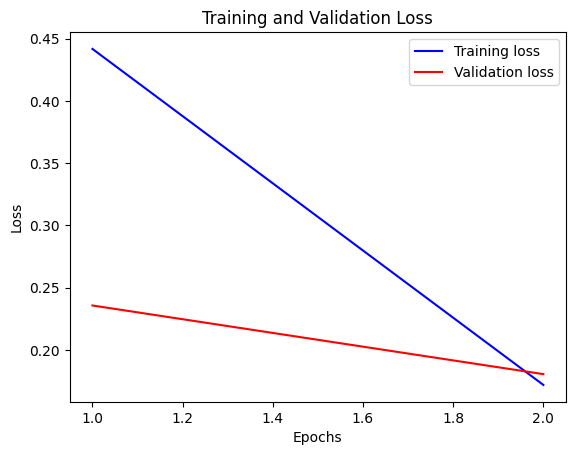

In [15]:

# Plotting the training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(loss) + 1)
plt.plot(epochs_range, loss, 'b', label='Training loss')
plt.plot(epochs_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


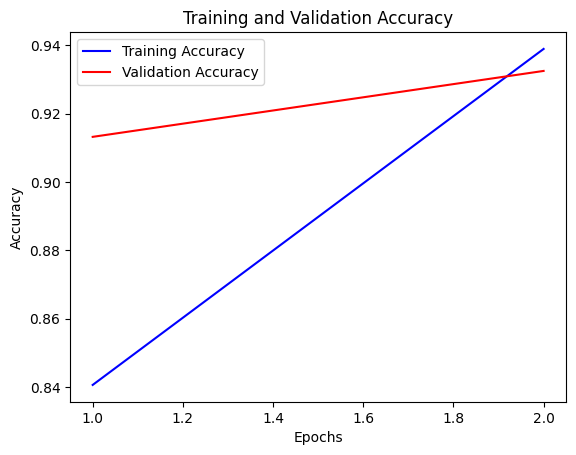

In [16]:
# Plotting the training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs_range, acc, 'b', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
# Confusion matrix generation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle

predictions = VGG_model.predict(val)
true_labels = np.concatenate([y for x, y in val], axis=0)
cm = confusion_matrix(true_labels, np.argmax(predictions, axis=1))

with open('confusion_matrix.pkl', 'wb') as f:
    pickle.dump(cm, f)


78/78 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step


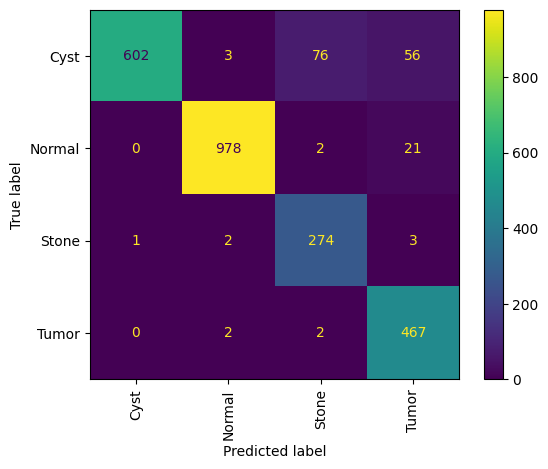

In [18]:
# Load and display the confusion matrix
with open('confusion_matrix.pkl', 'rb') as f:
    cm = pickle.load(f)

class_names = ['Cyst', 'Normal', 'Stone', 'Tumor']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='viridis', xticks_rotation='vertical', values_format='d')
plt.show()